# I. Tải các thư viện cần thiết

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import tqdm

In [ ]:
pip install ipywidgets

In [ ]:
from transformers import AutoImageProcessor, AutoTokenizer, VisionEncoderDecoderModel
from PIL import Image
import requests

# II. tải tập dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nunenuh/flickr30k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr30k


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nikhil7280/coco-image-caption")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/coco-image-caption


In [ ]:
# Define the file path
file_path = '/root/.cache/kagglehub/datasets/nunenuh/flickr30k/versions/1/captions.txt'

# Read the first 2 rows of the file
with open(file_path, 'r') as file:
    for i, line in enumerate(file):
        print(f"Line {i + 1}: {line.strip()}")
        if i == 1:  # Stop after 2 lines
            break

Line 1: image_name|caption_number|caption_text
Line 2: 1000092795.jpg|0|Two young guys with shaggy hair look at their hands while hanging out in the yard .


In [ ]:
import pandas as pd

# Define the file path
file_path = '/root/.cache/kagglehub/datasets/nunenuh/flickr30k/versions/1/captions.txt'

# Read the file, using the first line as header
flickr = pd.read_csv(file_path, delimiter='|')

In [ ]:
flickr.head()

,image_name,caption_number,caption_text
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,"Two young , White males are outside near many ..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [ ]:
flickr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   image_name      158915 non-null  object
 1   caption_number  158915 non-null  int64 
 2   caption_text    158915 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.6+ MB


In [ ]:
# Define the image folder path
image_folder = '/root/.cache/kagglehub/datasets/nunenuh/flickr30k/versions/1/images/flickr30k_images'

# Add a new column with the full image path
flickr['path'] = image_folder + '/' + flickr['image_name']

In [ ]:
flickr.head()

,image_name,caption_number,caption_text,path
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...,/root/.cache/kagglehub/datasets/nunenuh/flickr...
1,1000092795.jpg,1,"Two young , White males are outside near many ...",/root/.cache/kagglehub/datasets/nunenuh/flickr...
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,/root/.cache/kagglehub/datasets/nunenuh/flickr...
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,/root/.cache/kagglehub/datasets/nunenuh/flickr...
4,1000092795.jpg,4,Two friends enjoy time spent together .,/root/.cache/kagglehub/datasets/nunenuh/flickr...


In [ ]:
flickr=flickr[['image_name','caption_text','path']]

In [ ]:
pip install pycocotools

In [ ]:
import json
# Function to load JSON data from a file
def load_json(file_path):
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error decoding JSON from the file: {file_path}")
        return None

In [ ]:
# Load the data from the JSON file
train_caption_path = '/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/captions_train2014.json'
train_captions_data = load_json(train_caption_path)

val_caption_path = '/kaggle/input/coco-image-caption/annotations_trainval2017/annotations/captions_val2017.json'
val_captions_data = load_json(val_caption_path)

In [ ]:
train_captions_data.keys()

dict_keys(['info', 'images', 'licenses', 'annotations'])

In [ ]:
import pandas as pd

# Step 1: Prepare the image metadata
train_images_data = train_captions_data['images']
train_images_df = pd.DataFrame(train_images_data)

# Step 2: Prepare the captions data
train_annotations_data = train_captions_data['annotations']
train_annotations_df = pd.DataFrame(train_annotations_data)

# Step 3: Merge the image metadata and captions using 'image_id'
train_merged_df = pd.merge(train_annotations_df, train_images_df, left_on='image_id', right_on='id', suffixes=('_annotation', '_image'))

# Step 4: Select relevant columns (e.g., 'file_name', 'caption', 'width', 'height')
train_coco_df = train_merged_df[['image_id', 'file_name', 'caption', 'width', 'height']]

In [ ]:
import pandas as pd

# Step 1: Prepare the image metadata
val_images_data = val_captions_data['images']
val_images_df = pd.DataFrame(val_images_data)

# Step 2: Prepare the captions data
val_annotations_data = val_captions_data['annotations']
val_annotations_df = pd.DataFrame(val_annotations_data)

# Step 3: Merge the image metadata and captions using 'image_id'
val_merged_df = pd.merge(val_annotations_df, val_images_df, left_on='image_id', right_on='id', suffixes=('_annotation', '_image'))

# Step 4: Select relevant columns (e.g., 'file_name', 'caption', 'width', 'height')
val_coco_df = val_merged_df[['image_id', 'file_name', 'caption', 'width', 'height']]

In [ ]:
train_coco_df

,image_id,file_name,caption,width,height
0,318556,COCO_train2014_000000318556.jpg,A very clean and well decorated empty bathroom,480,640
1,116100,COCO_train2014_000000116100.jpg,A panoramic view of a kitchen and all of its a...,640,182
2,318556,COCO_train2014_000000318556.jpg,A blue and white bathroom with butterfly theme...,480,640
3,116100,COCO_train2014_000000116100.jpg,A panoramic photo of a kitchen and dining room,640,182
4,379340,COCO_train2014_000000379340.jpg,A graffiti-ed stop sign across the street from...,480,640
...,...,...,...,...,...
414108,133071,COCO_train2014_000000133071.jpg,a slice of bread is covered with a sour cream ...,640,360
414109,410182,COCO_train2014_000000410182.jpg,A long plate hold some fries with some sliders...,612,612
414110,180285,COCO_train2014_000000180285.jpg,Two women sit and pose with stuffed animals.,640,480
414111,133071,COCO_train2014_000000133071.jpg,White Plate with a lot of guacamole and an ext...,640,360


In [ ]:
val_coco_df

,image_id,file_name,caption,width,height
0,179765,000000179765.jpg,A black Honda motorcycle parked in front of a ...,640,480
1,179765,000000179765.jpg,A Honda motorcycle parked in a grass driveway,640,480
2,190236,000000190236.jpg,An office cubicle with four different types of...,640,393
3,331352,000000331352.jpg,A small closed toilet in a cramped space.,351,500
4,517069,000000517069.jpg,Two women waiting at a bench next to a street.,640,480
...,...,...,...,...,...
25009,9590,000000009590.jpg,A group of men sipping drinks and talking at a...,640,427
25010,84664,000000084664.jpg,"A plate of food with some eggs, potatoes, brea...",612,612
25011,331569,000000331569.jpg,The strawberries was sitting beside the tall g...,612,612
25012,231237,000000231237.jpg,A bunch of small red flowers in a barnacle enc...,334,500


/kaggle/input/coco-image-caption/train2014/train2014/COCO_train2014_000000000009.jpg

In [ ]:
# Define the image folder path

train_path='/kaggle/input/coco-image-caption/train2014/train2014'
val_path= '/kaggle/input/coco-image-caption/val2017/val2017'
# Add a new column with the full image path
train_coco_df['path'] = train_path +"/"+train_coco_df['file_name']
val_coco_df['path'] = val_path +"/"+val_coco_df['file_name']

<ipython-input-89-b9d7ba64f52d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coco_df['path'] = train_path +"/"+train_coco_df['file_name']
<ipython-input-89-b9d7ba64f52d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_coco_df['path'] = val_path +"/"+val_coco_df['file_name']


In [ ]:
train_coco_df['path'].iloc[0]

'/kaggle/input/coco-image-caption/train2014/train2014/COCO_train2014_000000318556.jpg'

In [ ]:
train_coco_df=train_coco_df[['caption','path','file_name']]
val_coco_df=val_coco_df[['caption','path','file_name']]

In [ ]:
train_coco_df.head()

,caption,path,file_name
0,A very clean and well decorated empty bathroom,/kaggle/input/coco-image-caption/train2014/tra...,COCO_train2014_000000318556.jpg
1,A panoramic view of a kitchen and all of its a...,/kaggle/input/coco-image-caption/train2014/tra...,COCO_train2014_000000116100.jpg
2,A blue and white bathroom with butterfly theme...,/kaggle/input/coco-image-caption/train2014/tra...,COCO_train2014_000000318556.jpg
3,A panoramic photo of a kitchen and dining room,/kaggle/input/coco-image-caption/train2014/tra...,COCO_train2014_000000116100.jpg
4,A graffiti-ed stop sign across the street from...,/kaggle/input/coco-image-caption/train2014/tra...,COCO_train2014_000000379340.jpg


In [ ]:
import pandas as pd

# Merge the two DataFrames (stack them vertically)
coco_df = pd.concat([train_coco_df, val_coco_df], ignore_index=True)

In [ ]:
coco_df

,caption,path,file_name
0,A very clean and well decorated empty bathroom,/kaggle/input/coco-image-caption/train2014/tra...,COCO_train2014_000000318556.jpg
1,A panoramic view of a kitchen and all of its a...,/kaggle/input/coco-image-caption/train2014/tra...,COCO_train2014_000000116100.jpg
2,A blue and white bathroom with butterfly theme...,/kaggle/input/coco-image-caption/train2014/tra...,COCO_train2014_000000318556.jpg
3,A panoramic photo of a kitchen and dining room,/kaggle/input/coco-image-caption/train2014/tra...,COCO_train2014_000000116100.jpg
4,A graffiti-ed stop sign across the street from...,/kaggle/input/coco-image-caption/train2014/tra...,COCO_train2014_000000379340.jpg
...,...,...,...
439122,A group of men sipping drinks and talking at a...,/kaggle/input/coco-image-caption/val2017/val20...,000000009590.jpg
439123,"A plate of food with some eggs, potatoes, brea...",/kaggle/input/coco-image-caption/val2017/val20...,000000084664.jpg
439124,The strawberries was sitting beside the tall g...,/kaggle/input/coco-image-caption/val2017/val20...,000000331569.jpg
439125,A bunch of small red flowers in a barnacle enc...,/kaggle/input/coco-image-caption/val2017/val20...,000000231237.jpg


In [ ]:
coco_df.rename(columns={'caption': 'caption_text'}, inplace=True)
coco_df.rename(columns={'file_name': 'image_name'}, inplace=True)
coco_df=coco_df[['image_name','caption_text','path']]

In [ ]:
flickr.head()

,image_name,caption_text,path
0,1000092795.jpg,Two young guys with shaggy hair look at their ...,/root/.cache/kagglehub/datasets/nunenuh/flickr...
1,1000092795.jpg,"Two young , White males are outside near many ...",/root/.cache/kagglehub/datasets/nunenuh/flickr...
2,1000092795.jpg,Two men in green shirts are standing in a yard .,/root/.cache/kagglehub/datasets/nunenuh/flickr...
3,1000092795.jpg,A man in a blue shirt standing in a garden .,/root/.cache/kagglehub/datasets/nunenuh/flickr...
4,1000092795.jpg,Two friends enjoy time spent together .,/root/.cache/kagglehub/datasets/nunenuh/flickr...


In [ ]:
coco_df.head()

,image_name,caption_text,path
0,COCO_train2014_000000318556.jpg,A very clean and well decorated empty bathroom,/kaggle/input/coco-image-caption/train2014/tra...
1,COCO_train2014_000000116100.jpg,A panoramic view of a kitchen and all of its a...,/kaggle/input/coco-image-caption/train2014/tra...
2,COCO_train2014_000000318556.jpg,A blue and white bathroom with butterfly theme...,/kaggle/input/coco-image-caption/train2014/tra...
3,COCO_train2014_000000116100.jpg,A panoramic photo of a kitchen and dining room,/kaggle/input/coco-image-caption/train2014/tra...
4,COCO_train2014_000000379340.jpg,A graffiti-ed stop sign across the street from...,/kaggle/input/coco-image-caption/train2014/tra...


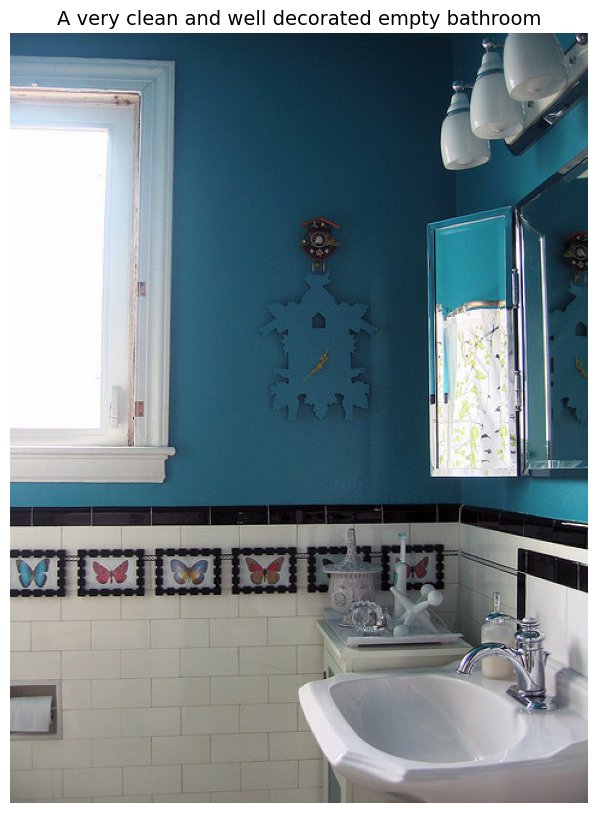

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Get the first image path and its caption
first_image_path = coco_df['path'].iloc[0]
first_caption = coco_df['caption_text'].iloc[0]

# Load the image
image = Image.open(first_image_path)

# Display the image along with the caption
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.title(first_caption, fontsize=14)
plt.show()

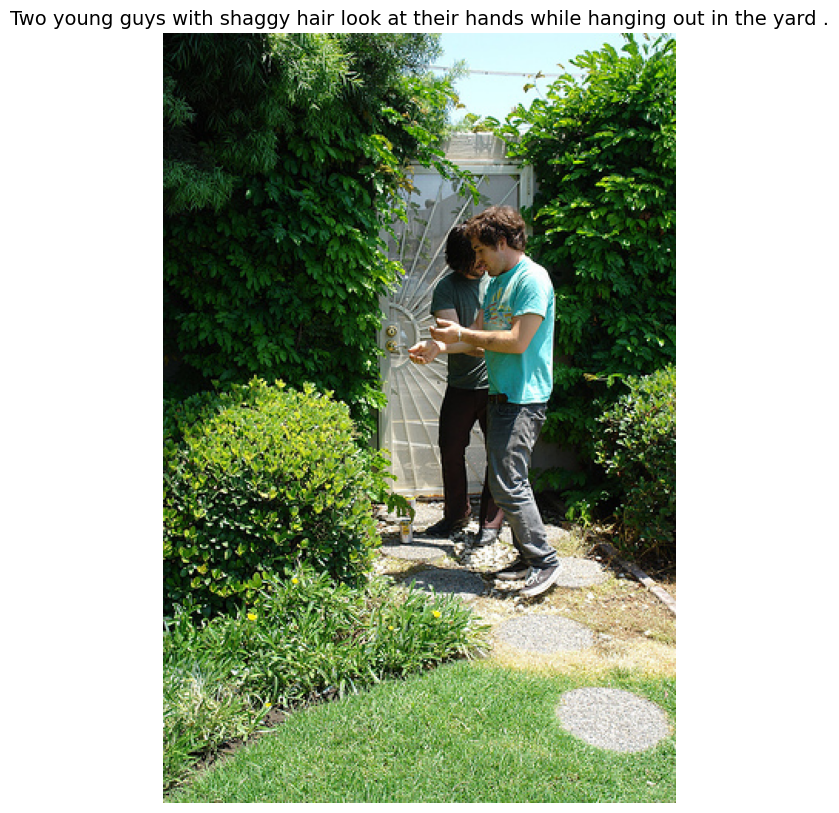

In [ ]:
# Get the first image path and its caption
first_image_path = flickr['path'].iloc[0]
first_caption = flickr['caption_text'].iloc[0]

# Load the image
image = Image.open(first_image_path)

# Display the image along with the caption
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.title(first_caption, fontsize=14)
plt.show()

In [ ]:
# Merge the train and validation DataFrames
df = pd.concat([flickr, coco_df], ignore_index=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598042 entries, 0 to 598041
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   image_name    598042 non-null  object
 1   caption_text  598042 non-null  object
 2   path          598042 non-null  object
dtypes: object(3)
memory usage: 13.7+ MB


In [ ]:
df.head()

,image_name,caption_text,path
0,1000092795.jpg,Two young guys with shaggy hair look at their ...,/root/.cache/kagglehub/datasets/nunenuh/flickr...
1,1000092795.jpg,"Two young , White males are outside near many ...",/root/.cache/kagglehub/datasets/nunenuh/flickr...
2,1000092795.jpg,Two men in green shirts are standing in a yard .,/root/.cache/kagglehub/datasets/nunenuh/flickr...
3,1000092795.jpg,A man in a blue shirt standing in a garden .,/root/.cache/kagglehub/datasets/nunenuh/flickr...
4,1000092795.jpg,Two friends enjoy time spent together .,/root/.cache/kagglehub/datasets/nunenuh/flickr...


# III. Phân chia dữ liệu

In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Get unique image names
image_names = df['image_name'].unique()

# Step 2: Split image names into training and temporary (validation + test) sets
train_image_names, temp_image_names = train_test_split(image_names, test_size=0.2, random_state=42)

# Step 3: Split the temporary image names into validation and test sets
val_image_names, test_image_names = train_test_split(temp_image_names, test_size=0.5, random_state=42)

# Step 4: Filter the original DataFrame based on the image names in each split
train_df = df[df['image_name'].isin(train_image_names)]
val_df = df[df['image_name'].isin(val_image_names)]
test_df = df[df['image_name'].isin(test_image_names)]

In [ ]:
print("Length of traning set",len(train_df))
print("Length of validation set",len(val_df))
print("Length of testing set",len(test_df))

Length of traning set 478427
Length of validation set 59807
Length of testing set 59808


In [ ]:
# Define a function to filter images based on DataFrame
def filter_images(df):
    filtered_images = [(row['path'], row['caption_text']) for index, row in df.iterrows()]
    return filtered_images

# Filter images for training and testing sets
train_images = filter_images(train_df)
test_images = filter_images(test_df)
val_images = filter_images(val_df)

# IV. Chuẩn bị dữ liệu cho việc huấn luyện mô hình

Tokenizer có nhiệm vụ biến đổi văn bản (text) thành các mã số (token IDs) để mô hình hiểu và xử lý được.

In [ ]:
from transformers import BertTokenizer
# Initiate bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

1.	Mã hóa (Encoding):
o	Trong lớp CaptionDataset, hàm encode_caption được sử dụng để mã hóa caption (chuỗi văn bản) thành một chuỗi các ID token bằng cách sử dụng BERT tokenizer (BertTokenizer.from_pretrained('bert-base-uncased')).
o	Quá trình này bao gồm:
	Thêm các token đặc biệt: [CLS] (bắt đầu câu) và [SEP] (kết thúc câu).
	Padding: Đệm các caption ngắn hơn độ dài tối đa bằng token padding (tokenizer.pad_token_id).
	Truncation: Cắt bớt các caption dài hơn độ dài tối đa.
	Chuyển đổi sang tensor: Chuyển đổi chuỗi các ID token thành tensor PyTorch.
2.	Giải mã (Decoding):
o	Hàm decode_caption (lớp CaptionDataset) được sử dụng để giải mã chuỗi các ID token trở lại thành chuỗi văn bản ban đầu.
o	Hàm này loại bỏ các token đặc biệt ([CLS] và [SEP]) trước khi giải mã.
3.	Chuyển đổi sang token:
o	Hàm convert_to_tokens (lớp CaptionDataset) được sử dụng để chuyển đổi chuỗi các ID token thành chuỗi các token văn bản tương ứng.


In [ ]:
from torch.utils.data import Dataset
import torch
from PIL import Image

# Định nghĩa lớp dataset tùy chỉnh để xử lý dữ liệu gồm ảnh và chú thích (caption)
class CaptionDataset(Dataset):
    def __init__(self, data, transform=None, tokenizer=tokenizer, max_length=50):
        """
        Khởi tạo dataset.

        Args:
            data (list of tuples): Danh sách gồm các cặp (image_path, caption)
            transform (callable, optional): Hàm biến đổi ảnh đầu vào (resize, normalize, ...)
            tokenizer (BertTokenizer): Tokenizer của BERT để mã hóa caption
            max_length (int): Độ dài tối đa cho mỗi caption (sẽ padding hoặc truncate)
        """
        self.data = data
        self.transform = transform
        self.max_length = max_length

        # Dùng tokenizer nếu đã có, nếu không sẽ khởi tạo mới
        self.tokenizer = tokenizer if tokenizer else BertTokenizer.from_pretrained('bert-base-uncased')

    # Hàm mã hóa caption từ dạng chuỗi sang tensor chứa ID của token
    def encode_caption(self, caption):
        """
        Chuyển caption (chuỗi) thành tensor ID bằng tokenizer BERT.
        """
        encoding = self.tokenizer.encode_plus(
            caption,
            add_special_tokens=True,      # Thêm token đặc biệt như [CLS], [SEP]
            padding='max_length',         # Padding đến độ dài cố định
            truncation=True,              # Cắt bớt nếu caption quá dài
            max_length=self.max_length,   # Độ dài tối đa
            return_tensors='pt',          # Trả về tensor PyTorch
        )
        return encoding['input_ids'].squeeze(0)  # Loại bỏ chiều batch

    # Hàm giải mã caption từ tensor ID về chuỗi
    def decode_caption(self, encoded_caption):
        """
        Chuyển tensor ID của caption thành chuỗi văn bản.
        """
        decoded_caption = self.tokenizer.decode(encoded_caption, skip_special_tokens=True)
        return decoded_caption

    # Hàm chuyển tensor ID thành các token string (dạng từ)
    def convert_to_tokens(self, encoded_caption):
        tokens_converted = self.tokenizer.convert_ids_to_tokens(encoded_caption)
        return tokens_converted

    # Trả về số lượng mẫu trong dataset
    def __len__(self):
        return len(self.data)

    # Hàm truy cập từng phần tử dataset bằng chỉ số
    def __getitem__(self, idx):
        """
        Trả về mẫu dữ liệu tại vị trí idx.

        Returns:
            tuple: (image, encoded_caption)
                - image: Tensor ảnh sau khi biến đổi (transform)
                - encoded_caption: Tensor ID của caption đã mã hóa
        """
        image_path, caption = self.data[idx]

        # Mở ảnh từ đường dẫn
        image = Image.open(image_path).convert('RGB')

        # Áp dụng transform nếu có (ví dụ resize, normalize, tensor hóa)
        if self.transform:
            image = self.transform(image)

        # Mã hóa caption bằng tokenizer
        encoded_caption = self.encode_caption(caption)

        return image, encoded_caption


In [ ]:
from torchvision import transforms

# Biến đổi cho tập huấn luyện: Bao gồm các phép biến đổi như lật ngang ngẫu nhiên, xoay, v.v.
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),               # Thay đổi kích thước ảnh về kích thước cố định 224x224
    transforms.RandomHorizontalFlip(),           # Lật ngang ảnh ngẫu nhiên
    transforms.RandomRotation(20),              # Xoay ảnh ngẫu nhiên với góc tối đa là 20 độ
    transforms.ToTensor(),                      # Chuyển ảnh thành tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Chuẩn hóa ảnh sử dụng các thông số trung bình và độ lệch chuẩn của ImageNet
])

# Biến đổi cho tập kiểm tra và xác nhận: Chỉ thay đổi kích thước và chuẩn hóa
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),               # Thay đổi kích thước ảnh về kích thước cố định 224x224
    transforms.ToTensor(),                       # Chuyển ảnh thành tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Chuẩn hóa ảnh sử dụng các thông số trung bình và độ lệch chuẩn của ImageNet
])


In [ ]:
# Create the CaptionDataset instance
train_dataset = CaptionDataset(data=train_images, transform=train_transform)
val_dataset = CaptionDataset(data=val_images, transform=val_test_transform)
test_dataset = CaptionDataset(data=test_images, transform=val_test_transform)

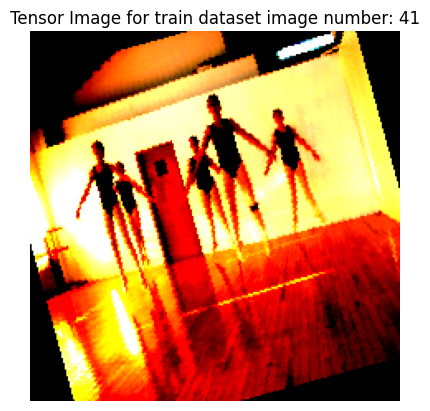

Tokenized Captions:
five ballet dancers caught mid jump in a dancing studio with sunlight coming through a window.
Encoded Tensor Captions:
tensor([  101,  2274,  7250, 10487,  3236,  3054,  5376,  1999,  1037,  5613,
         2996,  2007,  9325,  2746,  2083,  1037,  3332,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Tokenized Captions IDs:
['[CLS]', 'five', 'ballet', 'dancers', 'caught', 'mid', 'jump', 'in', 'a', 'dancing', 'studio', 'with', 'sunlight', 'coming', 'through', 'a', 'window', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
image_number = 40
#Random image
img_tensor, cap_tensor =  train_dataset[image_number]
# Convert the PyTorch tensor to a numpy array for displaying
image_np = img_tensor.permute(1, 2, 0).numpy()

# Display the image with title Tensor Image
plt.title(f"Tensor Image for train dataset image number: {image_number+1}")
plt.imshow(image_np)
plt.axis('off')
plt.show()

print("Tokenized Captions:")
print(train_dataset.decode_caption(cap_tensor))

# Display the captions
print("Encoded Tensor Captions:")
print(cap_tensor)

print("Tokenized Captions IDs:")
print(train_dataset.convert_to_tokens(cap_tensor))

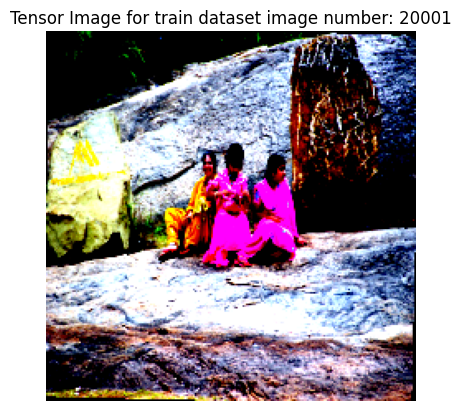

Tokenized Captions:
two ladies wear a pink saris with another lady in a gold sari while sitting on a rock.
Encoded Tensor Captions:
tensor([  101,  2048,  6456,  4929,  1037,  5061, 18906,  2483,  2007,  2178,
         3203,  1999,  1037,  2751, 18906,  2072,  2096,  3564,  2006,  1037,
         2600,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Tokenized Captions IDs:
['[CLS]', 'two', 'ladies', 'wear', 'a', 'pink', 'sar', '##is', 'with', 'another', 'lady', 'in', 'a', 'gold', 'sar', '##i', 'while', 'sitting', 'on', 'a', 'rock', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
image_number = 20000
#Random image
img_tensor, cap_tensor =  train_dataset[image_number]
# Convert the PyTorch tensor to a numpy array for displaying
image_np = img_tensor.permute(1, 2, 0).numpy()

# Display the image with title Tensor Image
plt.title(f"Tensor Image for train dataset image number: {image_number+1}")
plt.imshow(image_np)
plt.axis('off')
plt.show()

print("Tokenized Captions:")
print(train_dataset.decode_caption(cap_tensor))

# Display the captions
print("Encoded Tensor Captions:")
print(cap_tensor)

print("Tokenized Captions IDs:")
print(train_dataset.convert_to_tokens(cap_tensor))

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer
from torch.utils.data import DataLoader

# Hàm collate_fn dùng để xử lý batch ảnh và chú thích (caption)
def collate_fn(batch):
    """
    Hàm gom batch tùy chỉnh cho ảnh và caption, giúp padding và xử lý đúng định dạng.

    Args:
        batch (list of tuples): Mỗi phần tử là (image, caption)
            - image: tensor ảnh đã biến đổi
            - caption: chuỗi văn bản hoặc tensor đã mã hóa

    Returns:
        dict: Trả về dictionary gồm:
            - 'images': batch ảnh (tensor)
            - 'captions': batch caption đã padding (tensor)
    """

    images = []   # Danh sách để lưu các ảnh
    captions = [] # Danh sách để lưu các caption đã mã hóa

    # Khởi tạo tokenizer từ mô hình BERT
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Duyệt từng phần tử trong batch
    for image, caption in batch:
        # Lưu ảnh đã xử lý vào danh sách
        images.append(image)

        # Nếu caption là chuỗi (chưa mã hóa), thì mã hóa nó bằng BERT tokenizer
        if isinstance(caption, str):
            encoding = tokenizer.encode_plus(
                caption,                  # Văn bản gốc
                add_special_tokens=True, # Thêm [CLS] và [SEP]
                padding='max_length',    # Padding đến độ dài cố định
                truncation=True,         # Cắt nếu dài quá max_length
                max_length=50,           # Độ dài tối đa của caption
                return_tensors='pt'      # Trả về tensor
            )
            # Lấy input_ids và bỏ batch dimension (1, L) -> (L,)
            captions.append(encoding['input_ids'].squeeze(0))
        else:
            # Nếu caption đã là tensor, sao chép lại để tránh thay đổi dữ liệu gốc
            captions.append(caption.clone().detach())

    # Ghép các ảnh lại thành tensor dạng (batch_size, 3, H, W)
    images = torch.stack(images, dim=0)

    # Padding caption để tất cả có cùng độ dài, padding bằng token [PAD] của BERT
    captions = pad_sequence(captions, batch_first=True, padding_value=tokenizer.pad_token_id)

    return {
        'images': images,       # Tensor chứa batch ảnh
        'captions': captions    # Tensor chứa batch caption đã padding
    }


In [ ]:
batch_size = 32
# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn,num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn,num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn,num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Example of iterating through the DataLoader
for batch in train_loader:
    images = batch['images']
    captions = batch['captions']
#     print(batch)
    print("Batch of images:", images.shape)  # Should be [batch_size, 3, 224, 224]
    print("Batch of captions:", captions.shape)  # Should be [batch_size, max_caption_length]
    print("Captions:", captions)
    break  # For illustration, we break after the first batch

Batch of images: torch.Size([32, 3, 224, 224])
Batch of captions: torch.Size([32, 50])
Captions: tensor([[ 101, 1037, 2158,  ...,    0,    0,    0],
        [ 101, 1037, 2177,  ...,    0,    0,    0],
        [ 101, 1996, 6904,  ...,    0,    0,    0],
        ...,
        [ 101, 1037, 2158,  ...,    0,    0,    0],
        [ 101, 2019, 3746,  ...,    0,    0,    0],
        [ 101, 5013, 5666,  ...,    0,    0,    0]])


In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

def visual_images(train_loader,i=4):
    i=4
    for batch in train_loader:
        images = batch['images']
        captions = batch['captions']

        # Get the first image and its caption
        img_tensor = images[i]
        cap_tensor = captions[i]

        # Convert the PyTorch tensor to a numpy array for displaying
        image_np = img_tensor.permute(1, 2, 0).numpy()

        # Display the image with title Tensor Image
        plt.title(f"Tensor Image for train dataset image number: {image_number+1}")
        plt.imshow(image_np)
        plt.axis('off')
        plt.show()

        print("Tokenized Captions:")
        print(train_dataset.decode_caption(cap_tensor))
        # Display the captions
        print("Encoded Tensor Captions:")
        print(cap_tensor)

        break

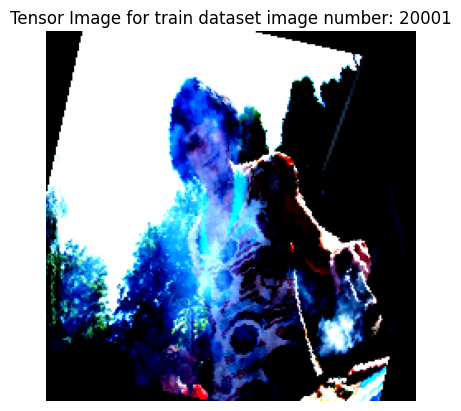

Tokenized Captions:
a woman cooking food on the grill.
Encoded Tensor Captions:
tensor([  101,  1037,  2450,  8434,  2833,  2006,  1996, 18651,  1012,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [ ]:
visual_images(train_loader,i=30000)

# V. Kiến trúc Encoder and decoder

•	**Encoder**: Trong kiến trúc mô hình sinh chú thích ảnh (image captioning), bộ mã hóa (Encoder) có vai trò trích xuất đặc trưng hình ảnh đầu vào. Mô hình sử dụng mạng ResNet-50 – một kiến trúc mạng nơ-ron tích chập sâu (CNN) đã được huấn luyện trước trên tập dữ liệu ImageNet – làm xương sống để trích xuất đặc trưng. Đây là phương pháp phổ biến trong học sâu khi xây dựng mô hình cho thị giác máy tính nhờ khả năng nhận diện hình ảnh hiệu quả.

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

# Encoder class: CNN feature extractor (e.g., ResNet)
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        # Using ResNet as the backbone for feature extraction
        resnet = models.resnet50(pretrained=True)  # Use ResNet-50

        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]  # Remove the fully connected layers
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)  # Output embedding size

    def forward(self, images):
        # Pass the image through ResNet
        with torch.no_grad():  # We don't need gradients for the ResNet part
            features = self.resnet(images)
        # Flatten the features and pass through the fully connected layer
        features = features.view(features.size(0), -1)
        features = self.fc(features)
        return features

•	**Decoder**: Sau khi ảnh đã được trích xuất đặc trưng bởi Encoder, bộ giải mã (Decoder) có nhiệm vụ chuyển đổi các vector đặc trưng này thành câu mô tả bằng ngôn ngữ tự nhiên. Trong mô hình này, Decoder được xây dựng dựa trên mạng LSTM kết hợp với cơ chế Attention, mang lại khả năng học được mối liên kết ngữ nghĩa tốt hơn giữa các từ trong chú thích

In [ ]:
import torch
import torch.nn as nn

# Định nghĩa lớp Decoder để sinh chú thích ảnh
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(Decoder, self).__init__()

        # Lớp nhúng từ (word embedding)
        self.embed = nn.Embedding(vocab_size, embed_size)

        # LSTM để xử lý chuỗi caption
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        # Lớp fully connected để dự đoán từ tiếp theo (dựa trên hidden state)
        self.fc_out = nn.Linear(hidden_size, vocab_size)

        # Cơ chế attention đa đầu (multi-head attention)
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=8)

        # Lưu các tham số đầu vào
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

    # Hàm lan truyền tiến (forward pass)
    def forward(self, features, captions):
        # Nhúng các từ trong caption thành vector
        embeddings = self.embed(captions)

        # Lấy đặc trưng ảnh để khởi tạo hidden state của LSTM
        h_0 = features.unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)

        # Cell state được khởi tạo bằng 0
        c_0 = torch.zeros_like(h_0)

        # Truyền chuỗi qua LSTM
        lstm_out, (h_n, c_n) = self.lstm(embeddings, (h_0, c_0))

        # Áp dụng attention vào đầu ra của LSTM
        attn_output, _ = self.attention(lstm_out, lstm_out, lstm_out)

        # Đưa qua fully connected để dự đoán từ tiếp theo
        output = self.fc_out(attn_output)

        return output

    # Hàm sinh caption bằng phương pháp greedy (tham lam)
    def greedy_decode(self, features, max_length=20, start_token=0, end_token=1):
        """
        Args:
            features (tensor): Đặc trưng ảnh (batch_size, embed_size)
            max_length (int): Độ dài tối đa của caption sinh ra
            start_token (int): Chỉ số của token <start>
            end_token (int): Chỉ số của token <end>
        """

        # Bắt đầu bằng token <start>
        input_caption = torch.tensor([[start_token]]).to(features.device)  # (1, 1) với batch_size = 1

        # Danh sách để lưu các từ sinh ra
        generated_caption = []

        # Khởi tạo hidden và cell state từ đặc trưng ảnh
        h_0 = features.unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)
        c_0 = torch.zeros_like(h_0)

        for _ in range(max_length):
            # Truyền caption hiện tại vào decoder để dự đoán từ tiếp theo
            output = self(input_caption, input_caption)

            # Lấy output tại bước thời gian cuối cùng
            output = output[:, -1, :]  # (batch_size, vocab_size)

            # Chọn từ có xác suất cao nhất
            _, predicted_token = torch.max(output, dim=1)

            # Thêm từ vào caption được sinh
            generated_caption.append(predicted_token.item())

            # Nếu gặp token kết thúc thì dừng
            if predicted_token.item() == end_token:
                break

            # Chuẩn bị token tiếp theo làm input cho bước tiếp theo
            input_caption = predicted_token.unsqueeze(0).unsqueeze(0)  # (1, 1)

        return generated_caption


In [ ]:
# Define a simple Image Captioning Model combining Encoder and Decoder
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = Encoder(embed_size)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [ ]:
# Model hyperparameters
embed_size = 512
hidden_size = 512
vocab_size=len(train_dataset.tokenizer.get_vocab())

In [ ]:
model = ImageCaptioningModel(embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s]


In [ ]:
model

ImageCaptioningModel(
  (encoder): Encoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True

# VI. Huấn luyện mô hình

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model.to(device)

ImageCaptioningModel(
  (encoder): Encoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True

In [ ]:
# Initialize the model, loss function, and optimizer
import torch.optim as optim

factor = 0.1
threshold = 0.01
min_lr = 1e-6
patience = 2
learning_rate = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=factor, threshold=threshold, min_lr=min_lr)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

# Initialize TensorBoard writer
writer = SummaryWriter("runs/flickr")
step = 0
save_model = True

# Early stopping and learning rate scheduling
best_val_loss = float('inf')
counter = 0  # Early stopping patience counter
patience = 5  # Number of epochs to wait before stopping
num_epochs = 2

# Lists to store metrics for analysis
train_losses = []
train_perplexities = []
val_losses = []
val_perplexities = []

# Main Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_perplexity = 0.0

    # Training loop with progress bar
    for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Training", unit="batch")):
        # Extract images and captions
        images_tensor = batch['images'].to(device)
        captions_tensor = batch['captions'].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images_tensor, captions_tensor)

        # Compute loss
        loss = criterion(outputs.view(-1, vocab_size), captions_tensor.view(-1))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item()
        running_perplexity += torch.exp(loss).item()

    # Average metrics for the epoch
    avg_loss = running_loss / len(train_loader)
    avg_perplexity = running_perplexity / len(train_loader)

    # Log training metrics to TensorBoard
    writer.add_scalar('Loss/train', avg_loss, epoch)
    writer.add_scalar('Perplexity/train', avg_perplexity, epoch)

    # Append to lists for analysis
    train_losses.append(avg_loss)
    train_perplexities.append(avg_perplexity)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_perplexity = 0.0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Validation", unit="batch"):
            # Extract validation images and captions
            images_tensor = batch['images'].to(device)
            captions_tensor = batch['captions'].to(device)

            # Forward pass
            outputs = model(images_tensor, captions_tensor)

            # Compute validation loss
            loss = criterion(outputs.view(-1, vocab_size), captions_tensor.view(-1))

            # Track validation metrics
            val_loss += loss.item()
            val_perplexity += torch.exp(loss).item()

    # Average validation metrics for the epoch
    avg_val_loss = val_loss / len(val_loader)
    avg_val_perplexity = val_perplexity / len(val_loader)

    # Log validation metrics to TensorBoard
    writer.add_scalar('Loss/val', avg_val_loss, epoch)
    writer.add_scalar('Perplexity/val', avg_val_perplexity, epoch)

    # Append validation metrics for analysis
    val_losses.append(avg_val_loss)
    val_perplexities.append(avg_val_perplexity)

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0  # Reset patience counter
        if save_model:
            torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1  # Increment patience counter if no improvement

    # Learning rate scheduler step
    scheduler.step(avg_val_loss)

    # Print epoch summary
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_loss:.4f}, Train Perplexity: {avg_perplexity:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Perplexity: {avg_val_perplexity:.4f} | "
          f"Learning Rate: {current_lr:.6f}")

    # Early stopping
    if counter >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Close TensorBoard writer after training
writer.close()


Epoch 1/2 Training:   0%|          | 0/14951 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/2 Validation: 100%|██████████| 1869/1869 [08:54<00:00,  3.50batch/s]


Epoch [1/2] | Train Loss: 0.1550, Train Perplexity: 11.4337 | Val Loss: 0.0550, Val Perplexity: 1.0573 | Learning Rate: 0.000100


Epoch 2/2 Training:  14%|█▎        | 2037/14951 [11:11<1:10:57,  3.03batch/s]


KeyboardInterrupt: 

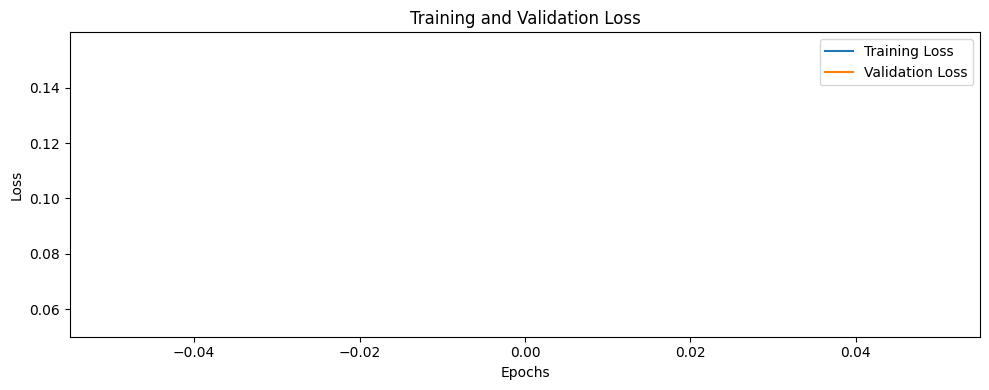

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Show the plots
plt.tight_layout()
plt.show()

# VII. Đánh giá mô hình trên test set

In [ ]:
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm

# Initialize lists to store images, predicted captions, ground truth captions, and BLEU scores
all_images = []
all_predicted_captions = []
all_ground_truth_captions = []
all_bleu_scores = []

# Define a function to calculate BLEU scores
def calculate_bleu(pred, refs):
    bleu_scores = []
    smoothing = SmoothingFunction()

    # Tokenization
    pred_tokens = pred.split()
    refs_tokens = [ref.replace('<start>', '').replace('<end>', '').split() for ref in refs]

    # Calculate BLEU-1, BLEU-2, BLEU-3, BLEU-4
    bleu1 = sentence_bleu(refs_tokens, pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothing.method1)
    bleu2 = sentence_bleu(refs_tokens, pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing.method1)
    bleu3 = sentence_bleu(refs_tokens, pred_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing.method1)
    bleu4 = sentence_bleu(refs_tokens, pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing.method1)

    bleu_scores.extend([bleu1, bleu2, bleu3, bleu4])

    return bleu_scores

In [ ]:
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing", unit="batch"):
        images_tensor = batch['images']
        captions_tensor = batch['captions']

        images_tensor, captions_tensor = images_tensor.to(device), captions_tensor.to(device)

        # Forward pass: Get the predictions from the model
        outputs = model(images_tensor, captions_tensor)

        for i in range(outputs.size(0)):  # Iterate over the batch
            # Get predicted caption
            predicted_caption = torch.argmax(outputs[i], dim=1)
            predicted_caption = predicted_caption.squeeze(0).cpu().numpy()
            decoded_caption = tokenizer.decode(predicted_caption, skip_special_tokens=True)

            # Get ground truth caption
            true_caption = captions_tensor[i].cpu().numpy()
            decoded_true_caption = tokenizer.decode(true_caption, skip_special_tokens=True)

            # Append results to the lists
            all_predicted_captions.append(decoded_caption)
            all_ground_truth_captions.append(decoded_true_caption)

            # Convert image from CHW to HWC and append it
            all_images.append(images_tensor[i].cpu().numpy().transpose(1, 2, 0))

            # Calculate BLEU scores for the current pair
            bleu_scores = calculate_bleu(decoded_caption, [decoded_true_caption])
            all_bleu_scores.append(bleu_scores)

Testing:  23%|██▎       | 435/1869 [02:29<11:00,  2.17batch/s]

# VIII. chỉ số BLEU của mô hình

In [ ]:
# Calculate the average BLEU scores
average_bleu_scores = [0, 0, 0, 0]  # BLEU-1, BLEU-2, BLEU-3, BLEU-4
for bleu_scores in all_bleu_scores:
    for i in range(4):
        average_bleu_scores[i] += bleu_scores[i]

# Compute the average BLEU scores
average_bleu_scores = [score / len(all_bleu_scores) for score in average_bleu_scores]

# Print the average BLEU scores
print("Average BLEU Scores:")
print("Average BLEU-1:", average_bleu_scores[0])
print("Average BLEU-2:", average_bleu_scores[1])
print("Average BLEU-3:", average_bleu_scores[2])
print("Average BLEU-4:", average_bleu_scores[3])


# IX. Dự đoán

In [ ]:
selected_images=all_images[0:10]
selected_prediction=all_predicted_captions[0:10]
selected_ground_truth_caption=all_ground_truth_captions[0:10]
# Now visualize the images with captions
for i in range(len(selected_images)):  # Loop over all_images, not the integer 10
    plt.imshow(selected_images[i])
    plt.axis('off')  # Hide axis
    plt.title(f"Predicted: {selected_prediction[i]}\nTrue: {selected_ground_truth_caption[i]}")
    plt.show()

In [ ]:
# Select the last 10 items from each list
selected_images = all_images[-10:]
selected_prediction = all_predicted_captions[-10:]
selected_ground_truth_caption = all_ground_truth_captions[-10:]

# Visualize the images with captions
for i in range(len(selected_images)):  # Loop over the selected_images list dynamically
    plt.imshow(selected_images[i])
    plt.axis('off')  # Hide axis
    plt.title(f"Predicted: {selected_prediction[i]}\nTrue: {selected_ground_truth_caption[i]}")
    plt.show()

# X. Lưu mô hình

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
from transformers import BertTokenizer

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/best_model.pth')

In [ ]:
model.eval()

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# Đường dẫn đến ảnh mới
image_path = "/content/drive/MyDrive/Colab Notebooks/CuoiKi_deeplearning/cuoiki.jpg"

# Tải ảnh
image = Image.open(image_path).convert('RGB')

# Biến đổi
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Thay đổi kích thước nếu cần
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image = transform(image).unsqueeze(0)  # unsqueeze để thêm chiều batch

In [ ]:
# Chuyển đến thiết bị
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Define the device
image = image.to(device)
# Move the model to the same device as the input image
model.to(device)

with torch.no_grad():
    features = model.encoder(image)  # Get features from encoder
    generated_caption = model.decoder.greedy_decode(features, torch.tensor([[tokenizer.cls_token_id]]).to(device))

decoded_caption = tokenizer.decode(generated_caption, skip_special_tokens=True)
print(decoded_caption)

# XI. Load Mô hình

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Model hyperparameters
embed_size = 512
hidden_size = 512
vocab_size= 30522

In [ ]:
model = ImageCaptioningModel(embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size)

In [ ]:
# Load the model's state dictionary and map it to the CPU
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/CuoiKi_deeplearning/best_model.pth', map_location=torch.device('cpu')))

In [ ]:
model.eval()

In [ ]:
# Chuyển đến thiết bị
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Define the device
# Move the model to the same device as the input image
model.to(device)